In [74]:
from cltk import NLP
from cltk.languages.example_texts import get_example_text
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [76]:
# import cicero speeches raw text
with open("incat.txt") as fo:
    cicero = fo.read()
print("Text snippet:", cicero[:1000])
print("Character count:", len(cicero))
print("Approximate token count:", len(cicero.split()))

Text snippet: M. TULLI CICERONIS
ORATIO IN CATILINAM PRIMA
IN SENATU HABITA

Quo usque tandem abutere, Catilina, patientia nostra?  quam diu etiam
furor iste tuus nos eludet?  quem ad finem sese effrenata iactabit
audacia?  Nihilne te nocturnum praesidium Palati, nihil urbis vigiliae,
nihil timor populi, nihil concursus bonorum omnium, nihil hic munitissimus
habendi senatus locus, nihil horum ora voltusque moverunt?  Patere tua
consilia non sentis, constrictam iam horum omnium scientia teneri
coniurationem tuam non vides?  Quid proxima, quid superiore nocte egeris,
ubi fueris, quos convocaveris, quid consilii ceperis, quem nostrum
ignorare arbitraris?  O tempora, o mores! Senatus haec intellegit.  consul
videt; hic tamen vivit.  Vivit?  immo vero etiam in senatum venit, fit
publici consilii particeps, notat et designat oculis ad caedem unum
quemque nostrum.  Nos autem fortes viri satis facere rei publicae videmur,
si istius furorem ac tela vitemus.  Ad mortem te, Catilina, duci iussu
c

In [77]:
from cltk import NLP
from tqdm.auto import tqdm
cltk_nlp = NLP(language="lat")
%time cic_doc = cltk_nlp.analyze(text=cicero)

‎𐤀 CLTK version '1.1.6'.
Pipeline for language 'Latin' (ISO: 'lat'): `LatinNormalizeProcess`, `LatinStanzaProcess`, `LatinEmbeddingsProcess`, `StopsProcess`, `LatinLexiconProcess`.
CPU times: user 16min 3s, sys: 1.82 s, total: 16min 5s
Wall time: 16min 2s


In [78]:
import pandas as pd
from cltk.core.data_types import Doc

def subset_pos(cic_doc):
    pos_dict = {}

    for word in cic_doc.words:
        pos = str(word.pos)  # Convert POS object to string

        if pos not in pos_dict:
            pos_dict[pos] = []

        pos_dict[pos].append(word)

    return pos_dict

def create_pos_dataframes(cic_doc):
    pos_subsets = subset_pos(cic_doc)
    pos_dfs = {}

    for pos, words in pos_subsets.items():
        words_data = []

        for word in words:
            word_data = {
                'index_char_start': word.index_char_start,
                'index_char_stop': word.index_char_stop,
                'index_token': word.index_token,
                'index_sentence': word.index_sentence,
                'string': word.string,
                'pos': word.pos,
                'lemma': word.lemma,
                'stem': word.stem,
                'scansion': word.scansion,
                'xpos': word.xpos,
                'upos': word.upos,
                'dependency_relation': word.dependency_relation,
                'governor': word.governor,
                'category': word.category,
                'stop': word.stop,
                'named_entity': word.named_entity,
                'syllables': word.syllables,
                'phonetic_transcription': word.phonetic_transcription,
                'definition': word.definition
            }

            for feature, value in word.features.items():
                word_data[str(feature)] = str(value[0]) if value else None

            words_data.append(word_data)

        pos_dfs[pos] = pd.DataFrame(words_data)

    return pos_dfs

pos_dataframes = create_pos_dataframes(cic_doc)
noun_dataframe = pos_dataframes['noun']
adjective_dataframe = pos_dataframes['adjective']
proper_noun_dataframes = pos_dataframes['proper_noun']
Coordconj_dataframes = pos_dataframes['coordinating_conjunction']
particle_dataframe = pos_dataframes['particle']
proper_noun_dataframe = pos_dataframes['proper_noun']
verb_dataframe = pos_dataframes['verb']

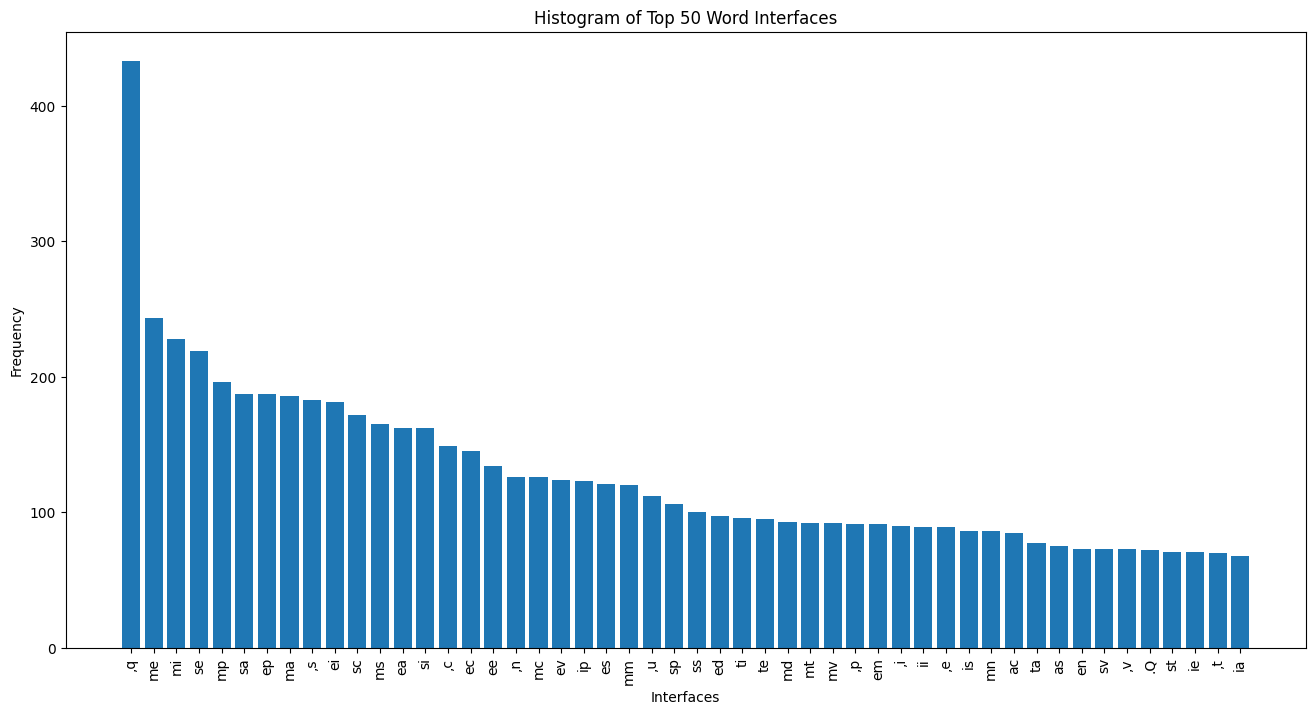

In [84]:
# BAILLY EMAIL
# Word interface analysis: Extract the last character of a word and the first character of the next word.
def word_interface(text):
    words = text.split()
    interfaces = [words[i][-1] + words[i + 1][0] for i in range(len(words) - 1)]
    return interfaces


# Analyze word interfaces
word_interfaces = word_interface(cicero)
#print(word_interfaces)

import matplotlib.pyplot as plt
from collections import Counter

def plot_interface_histogram(interfaces, n_top=50):
    interface_counter = Counter(interfaces)
    
    # Sort interfaces by frequency and take the top 50
    sorted_interfaces = sorted(interface_counter.items(), key=lambda x: x[1], reverse=True)[:n_top]

    # Extract interface labels and counts
    labels, counts = zip(*sorted_interfaces)

    # Plot the histogram
    plt.figure(figsize=(16, 8))
    plt.bar(labels, counts)
    plt.xlabel('Interfaces')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Top {n_top} Word Interfaces')
    plt.xticks(rotation=90)
    plt.show()


interfaces = word_interface(cicero)
plot_interface_histogram(interfaces)



In [85]:
import re

def extract_vowel_ngrams(text, n):
    vowels = "aeiouyAEIOUY"
    vowel_pattern = re.compile(f"[{vowels}]{{{n}}}")
    return re.findall(vowel_pattern, text)
# Analyze vowel n-grams (2-grams and 3-grams)
vowel_2grams = extract_vowel_ngrams(cicero, 2)
vowel_3grams = extract_vowel_ngrams(cicero, 3)
#print(vowel_2grams)
#print(vowel_3grams)

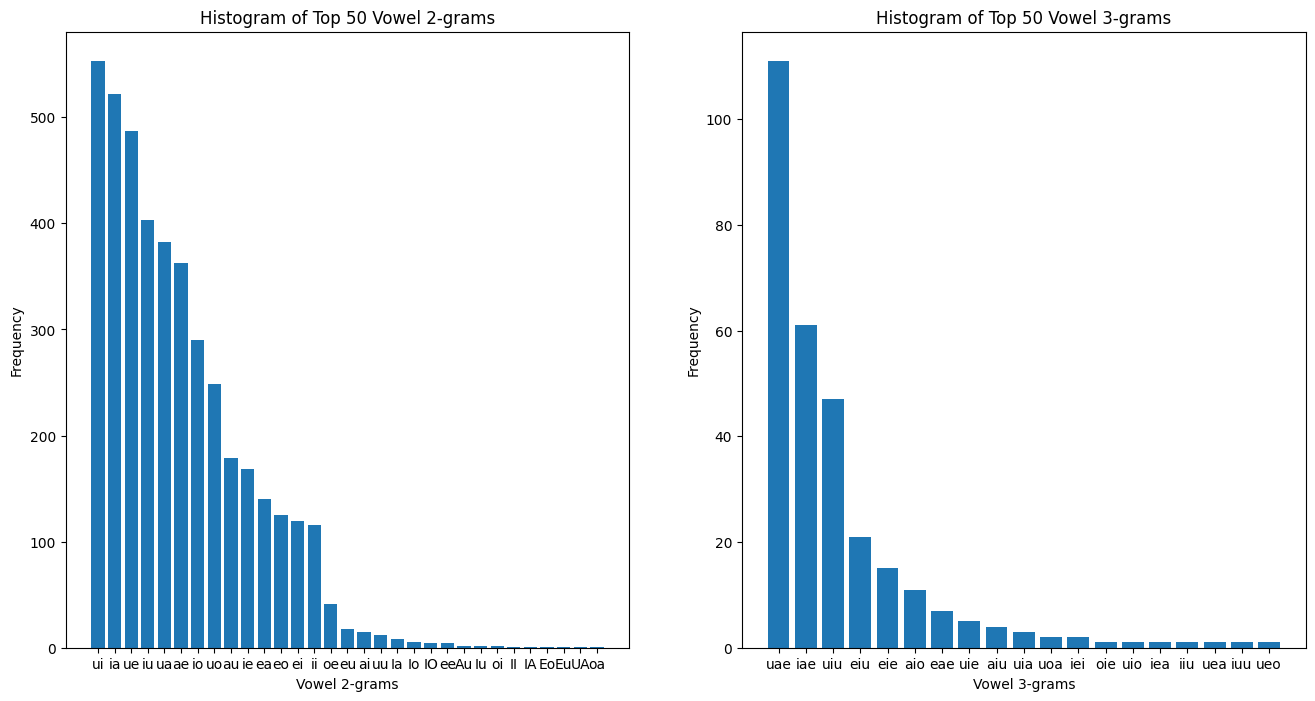

In [86]:
# Get the top 50 n-grams and their frequencies
top_50_2grams = Counter(vowel_2grams).most_common(50)
top_50_3grams = Counter(vowel_3grams).most_common(50)

# Plot the histograms
plt.figure(figsize=(16, 8))

# Plot the vowel 2-grams histogram
plt.subplot(1, 2, 1)
plt.bar([ngram for ngram, count in top_50_2grams], [count for ngram, count in top_50_2grams])
plt.xlabel('Vowel 2-grams')
plt.ylabel('Frequency')
plt.title('Histogram of Top 50 Vowel 2-grams')

# Plot the vowel 3-grams histogram
plt.subplot(1, 2, 2)
plt.bar([ngram for ngram, count in top_50_3grams], [count for ngram, count in top_50_3grams])
plt.xlabel('Vowel 3-grams')
plt.ylabel('Frequency')
plt.title('Histogram of Top 50 Vowel 3-grams')

plt.show()

In [82]:
#syllabify 
from cltk.phonology.lat.phonology import LatinTranscription, syllabify
for i in range(len(cic_doc.words)):
    cic_doc.words[i].syllables = syllabify(cic_doc.words[i].string)
# I can even transcribe and store the hypothetical pronunciation, but I won't do that now.
# what are more things an author doesn't plausibly control for?

#Word frequency distribution: The frequency of certain words in a text might reveal patterns or preferences the author might not be consciously aware of. Comparing the distribution to other works by the same author or different authors can provide insights into an author's unique voice or shared influences.
#Collocations: These are combinations of words that frequently appear together, and may reveal unconscious tendencies in an author's word choice. For example, an author might consistently pair certain adjectives with specific nouns without consciously intending to do so.
#N-grams: Sequences of n words that appear together in a text can reveal patterns in an author's writing. By analyzing the frequency and distribution of n-grams, you can identify unconscious preferences in word combinations or sentence structures.
#Syntactic patterns: Analyzing the syntax of sentences, such as the frequency and distribution of different clause structures or types of phrases, may reveal unconscious patterns in an author's writing style.
#Lexical diversity: The range of vocabulary used in a text can provide insights into an author's unconscious tendencies in word choice. A higher lexical diversity might indicate a richer vocabulary or a more varied writing style, whereas a lower lexical diversity might suggest a more repetitive or formulaic approach.
#Sentiment analysis: By assessing the overall sentiment of a text (e.g., positive, negative, or neutral), you can identify the unconscious emotional tone or mood the author creates in their work.
#Readability scores: Metrics such as the Flesch-Kincaid Grade Level or the Gunning Fog Index can give an indication of the complexity of an author's writing, which might be influenced unconsciously by their intended audience or their own writing preferences.
